# Data preprocessing
2018 is expected split to months in the same way as later data.

In [1]:
import os

import numpy as np
import pandas as pd

data_raw = './data/nosync/data_raw'
data_csv = './data/nosync/data_csv'
data_csv_reduced = './data/nosync/data_csv_reduced'

# Prepare the processing pipeline
pipeline = []


## Load data from XML

In [2]:
from xml.etree import ElementTree as ET


def read_xml(path):
    file = path

    # Remove newlines.
    clean = open(file, encoding='utf8').read().replace('\n', '')
    f = open(file, 'w', encoding='utf8')
    f.write(clean)
    f.close()

    StationId = []
    Type = []
    VIN = []
    Date = []
    Make = []
    MotorType = []
    VehicleType = []
    Model = []
    VehicleClass = []
    FirstRegistrationDate = []
    Km = []
    Defects = []
    Result = []

    # Parsing
    parser = ET.iterparse(file)
    for _, element in parser:
        if element.tag == 'record':

            if 'STK' in element.attrib:
                StationId.append(element.attrib['STK'])
            elif 'CisP' in element.attrib:
                StationId.append(element.attrib['CisP'].split('-')[1])
            else:
                StationId.append('')

            if 'DrTP' in element.attrib:
                Type.append(element.attrib['DrTP'])
            else:
                Type.append('')

            if 'VIN' in element.attrib:
                VIN.append(element.attrib['VIN'])
            else:
                VIN.append('')

            if 'DatKont' in element.attrib:
                Date.append(element.attrib['DatKont'])
            else:
                Date.append('')

            if 'TZn' in element.attrib:
                Make.append(element.attrib['TZn'])
            else:
                Make.append('')

            if 'TypMot' in element.attrib:
                MotorType.append(element.attrib['TypMot'])
            else:
                MotorType.append('')

            if 'DrVoz' in element.attrib:
                VehicleType.append(element.attrib['DrVoz'])
            else:
                VehicleType.append('')

            if 'ObchOznTyp' in element.attrib:
                Model.append(element.attrib['ObchOznTyp'])
            else:
                Model.append('')

            if 'Ct' in element.attrib:
                VehicleClass.append(element.attrib['Ct'])
            else:
                VehicleClass.append('')

            if 'DatPrvReg' in element.attrib:
                FirstRegistrationDate.append(element.attrib['DatPrvReg'])
            else:
                FirstRegistrationDate.append('')

            if 'Km' in element.attrib:
                Km.append(element.attrib['Km'])
            else:
                Km.append('')

            if 'Zav' in element.attrib:
                Defects.append(element.attrib['Zav'])
            else:
                Defects.append('')

            if 'VyslSTK' in element.attrib:
                Result.append(element.attrib['VyslSTK'])
            elif 'Vysl' in element.attrib:
                Result.append(element.attrib['Vysl'])
            else:
                Result.append('')

            element.clear()

    data = pd.DataFrame({
        'StationId': StationId,
        'Type': Type,
        'VIN': VIN,
        'Date': Date,
        'MotorType': MotorType,
        'Make': Make,
        'VehicleType': VehicleType,
        'Model': Model,
        'VehicleClass': VehicleClass,
        'FirstRegistrationDate': FirstRegistrationDate,
        'Km': Km,
        'Defects': Defects,
        'Result': Result
    })

    return data


In [43]:
# Test

df = read_xml(f'data/nosync/data_raw/Data_2021/Data_Prohlidek_2021_06.xml')

## Basic row filtering

### Standardize missing values

In [54]:
# Replace `---` with np.nan

def process_missing(df: pd.DataFrame, _):
    df = df.replace('---', np.NaN)
    return df.replace('', np.NaN)


pipeline.append(process_missing)


### Vehicle types

In [55]:
types_to_retain = [
    'OSOBNÍ AUTOMOBIL',
    'NÁKLADNÍ AUTOMOBIL',
    'MOTOCYKL',
    # 'AUTOBUS'
]


def filter_vehicle_types(df: pd.DataFrame, _):
    return df[df['VehicleType'].isin(types_to_retain)]


pipeline.append(filter_vehicle_types)


### Incomplete and duplicate rows

In [56]:
def filter_duplicates(df: pd.DataFrame, _):
    return df.drop_duplicates(keep='first')


def filter_incomplete(df: pd.DataFrame, name: str):
    # For 2018, do not drop rows with missing defects (they are all missing)
    if name.startswith('2018'):
        return df.dropna(how='any', subset=[
            'StationId',
            'Type',
            'VIN',
            'Date',
            'MotorType',
            'Make',
            'VehicleType',
            'Model',
            'VehicleClass',
            'FirstRegistrationDate',
            'Km',
            # 'Defects',
            'Result',
        ])
    
    return df.dropna(how='any')


pipeline.append(filter_duplicates)
pipeline.append(filter_incomplete)


### Malformed VINs
Only accept standard VINs consisting of 17 characters.

In [57]:
def filter_vins(df: pd.DataFrame, _):
    return df[df['VIN'].str.len() == 17]

pipeline.append(filter_vins)


## Transformations per type
Process the dataframe per column.

### Station ID
Retain only rows with inspections at known stations (those which are present in the station list).

In [58]:
stations = pd.read_csv('../station_list/data/station_list.csv', index_col=0, dtype='str')
station_ids = list(stations['STK'])

def filter_unknown_stations(df: pd.DataFrame, _):
    return df[df['StationId'].isin(station_ids)]

pipeline.append(filter_unknown_stations)

In [59]:
# Test

removed = df[df['StationId'].isin(station_ids).apply(lambda x: not x)]

uniq = removed['Date'].unique()
uniq.sort()
display(len(df) - len(df[df['StationId'].isin(station_ids)]))
display(uniq)

2584

array(['01.06.2021', '02.06.2021', '03.06.2021', '04.06.2021',
       '05.06.2021', '07.06.2021', '08.06.2021', '09.06.2021',
       '10.06.2021', '11.06.2021', '12.06.2021', '13.06.2021',
       '14.06.2021', '15.06.2021', '16.06.2021', '17.06.2021',
       '18.06.2021', '19.06.2021', '20.06.2021', '21.06.2021',
       '22.06.2021', '23.06.2021', '24.06.2021', '25.06.2021',
       '26.06.2021', '27.06.2021', '28.06.2021', '29.06.2021',
       '30.06.2021'], dtype=object)

### Inspection type

In [60]:
def transform_inspection_type(df: pd.DataFrame, _):
    # Should be already inferred, do this just to be sure.
    df['Type'] = df['Type'].astype('category')
    
    df['Type'] = df['Type'].cat.rename_categories({
        'pravidelná': 'pravidelná',
        'Evidenční kontrola': 'evidenční',
        'Před registrací': 'před registrací',
        'opakovaná': 'opakovaná',
        'Na žádost zákazníka': 'na žádost zákazníka',
        'Před registrací - opakovaná': 'před registrací - opakovaná',
        'ADR': 'ADR',
        'Před schvál. tech. způsob. vozidla': 'před schválením tech. zp.',
        'Nařízená technická prohlídka': 'nařízená',
        'TSK - Opakovaná': 'silniční - opakovaná',
        'Technická silniční kontrola': 'silniční',
        'TSK - Opakovaná po DN': 'silniční - opakovaná po DN',
        'Před schvál. tech. způsob. vozidla - opakovaná': 'před schválením tech. zp. - opakovaná',
        'ADR - opakovaná': 'ADR - opakovaná',
    })

    return df


pipeline.append(transform_inspection_type)


In [11]:
# Test

# display(df.dtypes)
df = transform_inspection_type(df, None)
display(df.size)
# df['Type'] = df['Type'].astype('category')
# for val in df['Type'].unique():
#     print(val)


5513391

### Date format
Format the dates and drop rows with invalid dates.

In [61]:
# Split Date and FirstRegistrationDate to separate year, month, day columns. Add weekday indicator.
# Convert dates to a pandas date.
# 2018-01 => 2019-03  yyyy-mm-ddThh:mm:ss.sss
# 2019-04 => 2019-07  mm/dd/yyyy
# 2019-08+            dd.mm.yyyy

def format_date_v1(df: pd.DataFrame):
    df['Date'] = pd.to_datetime(
        df['Date'], format='%Y-%m-%d', exact=False, errors='coerce')
    df['FirstRegistrationDate'] = pd.to_datetime(
        df['FirstRegistrationDate'], format='%Y-%m-%d', exact=False, errors='coerce')
    return df


def format_date_v2(df):
    df['Date'] = pd.to_datetime(
        df['Date'], format='%m/%d/%Y', exact=True, errors='coerce')
    df['FirstRegistrationDate'] = pd.to_datetime(
        df['FirstRegistrationDate'], format='%m/%d/%Y', exact=True, errors='coerce')
    return df


def format_date_v3(df):
    df['Date'] = pd.to_datetime(
        df['Date'], format='%d.%m.%Y', exact=True, errors='coerce')
    df['FirstRegistrationDate'] = pd.to_datetime(
        df['FirstRegistrationDate'], format='%d.%m.%Y', exact=True, errors='coerce')
    return df


def format_date(df: pd.DataFrame, name: str):
    # Convert to datetime based on file version
    if name.__contains__('2018') or name.__contains__('2019-01') \
            or name.__contains__('2019-02') or name.__contains__('2019-03'):
        df = format_date_v1(df)
    elif name.__contains__('2019-04') or name.__contains__('2019-05') \
            or name.__contains__('2019-06') or name.__contains__('2019-07'):
        df = format_date_v2(df)
    else:
        df = format_date_v3(df)

    # Drop invalid rows
    df = df.dropna(how='any', subset=['Date', 'FirstRegistrationDate'])

    return df


pipeline.append(format_date)


In [62]:
def filter_dates_out_of_range(df: pd.DataFrame, name: str):
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])

    start = f'{year}-{month:02}-01'
    if month < 12:
        end = f'{year}-{month + 1:02}-01'
    else:
        end = f'{year + 1}-01-01'

    return df[(df['Date'] >= start) & (df['Date'] < end)]

pipeline.append(filter_dates_out_of_range)


In [14]:
# Test
print(len(df))
df_form = format_date(df, '2021-06')
print(len(df_form))
df_dates = filter_dates_out_of_range(df_form, '2021-06')
print(len(df_dates))

424107
421239
421239


### Model
Group model types such as "OCTAVIA GLX", "OCTAVIA RS".
This is just temporary for EDA, won't be used further as registration info will be taken from the vehicle register.

In [63]:
def group_models(df: pd.DataFrame, _) -> pd.DataFrame:
    # Strip trailing content in parentheses.
    df['Model'] = df['Model'].apply(lambda x: x.split('(')[0].strip())
    # Remove special characters and duplicate spaces
    df['Model'] = df['Model'].str.replace('[^\w\s]', '', regex=True)
    df['Model'] = df['Model'].str.replace('  ', ' ')
    df['Model'] = df['Model'].str.replace('   ', ' ')

    # Obtain counts of single-word values in the column.
    sws = df[df['Model'].apply(lambda x: len(x.split(' '))) == 1]['Model'].to_numpy()
    sws_uniq, sws_cnt = np.unique(sws, return_counts=True)

    # Obtain counts of two-word values in the column.
    tws = df[df['Model'].apply(lambda x: len(x.split(' '))) == 2]['Model'].to_numpy()
    tws_uniq, tws_cnt = np.unique(tws, return_counts=True)

    # For each make, group two-word values with <25 occurences whose first-word-only instance has >50 occurences
    # and group similarly seldom appearing multiword (3+ words) values to often appearing two-word values.
    # When a multiword value is seldom, replace it with the first-word-only value when that has enough occurences.
    by_make = df.groupby('Make')
    for make, mdf in by_make:
        # print(f'Make: {make}')
        # Obtain counts of two-word values.
        twv = mdf[mdf['Model'].apply(lambda x: len(x.split(' '))) == 2]['Model'].to_numpy()
        twv_uniq, twv_cnt = np.unique(twv, return_counts=True)

        # print(twv_uniq)
        
        for val, cnt in zip(twv_uniq, twv_cnt):
            if cnt < 25:
                # print(f'Found a candidate: {val}')
                # Find a corresponding single-word value.
                fwp = val.split(' ')[0]
                indices = np.where(sws_uniq == fwp)[0]
                # Check if the count of the single-word value is big enough.
                if indices.size > 0 and sws_cnt[indices[0]] > 50:
                    # Group to the single-word value
                    # print(f'Good 2w candidate: {val} ({cnt}) (group to "{sws_uniq[indices[0]]}" with {sws_cnt[indices[0]]} occrs)')
                    df.loc[(by_make.as_index) & (df['Model'] == val), 'Model'] = fwp
                    continue
        
        # Obtain counts of two-word values.
        mwv = mdf[mdf['Model'].apply(lambda x: len(x.split(' '))) >= 3]['Model'].to_numpy()
        mwv_uniq, mwv_cnt = np.unique(mwv, return_counts=True)

        # print(mwv_uniq)
        
        for val, cnt in zip(mwv_uniq, mwv_cnt):
            if cnt < 25:
                # print(f'Found a candidate: {val}')
                # Find a corresponding single-word value.
                twp = ' '.join(val.split(' ')[0:2])
                indices = np.where(tws_uniq == twp)[0]
                # Check if the count of the single-word value is big enough.
                if indices.size > 0 and tws_cnt[indices[0]] > 50:
                    # Group to the single-word value
                    # print(f'Good mw candidate: {val} (group to "{tws_uniq[indices[0]]}" with {tws_cnt[indices[0]]} occrs)')
                    df.loc[(by_make.as_index) & (df['Model'] == val), 'Model'] = twp
                    continue
                # Check if the first-word-only variant has enough occurences.
                else:
                    fwp = val.split(' ')[0]
                    indices = np.where(sws_uniq == fwp)[0]
                    # Check if the count of the single-word value is big enough.
                    if indices.size > 0 and sws_cnt[indices[0]] > 50:
                        # Group to the single-word value
                        # print(f'Good mw->1w candidate: {val} ({cnt}) (group to "{sws_uniq[indices[0]]}" with {sws_cnt[indices[0]]} occrs)')
                        df.loc[(by_make.as_index) & (df['Model'] == val), 'Model'] = fwp
                        continue

    return df

pipeline.append(group_models)

Make: 
Make: A. SCHUH
Make: ACCESS
Make: ACURA
Make: ADAMS
Make: ADIVA
Make: ADLY
Make: ADRIA
Good mw->1w candidate: MATRIX M 680SL (1) (group to "MATRIX" with 176 occrs)
Make: AEBI
Make: AEON
Make: AERMACCHI
Make: AERO
Make: AGADOS
Make: AGM
Make: AIE
Make: AIXAM
Good 2w candidate: CITY SPORT (1) (group to "CITY" with 59 occrs)
Make: AJP
Make: AJS
Make: AKUMOTO
Make: ALFA ROMEO
Good 2w candidate: 156 SPORTSWAGON (1) (group to "156" with 150 occrs)
Good 2w candidate: 156 SPORTWAGON (2) (group to "156" with 150 occrs)
Good 2w candidate: GIULIETTA 940 (4) (group to "GIULIETTA" with 65 occrs)
Good mw->1w candidate: 156 19 JTD (1) (group to "156" with 150 occrs)
Make: ALPINA
Make: ALTENBERGE
Make: AMC
Make: APRILIA
Good 2w candidate: 125 ENDURO (1) (group to "125" with 291 occrs)
Good 2w candidate: 125 RS (1) (group to "125" with 291 occrs)
Good 2w candidate: 50 RALLY (5) (group to "50" with 239 occrs)
Good 2w candidate: 50 SR (1) (group to "50" with 239 occrs)
Good 2w candidate: SCARABEO 

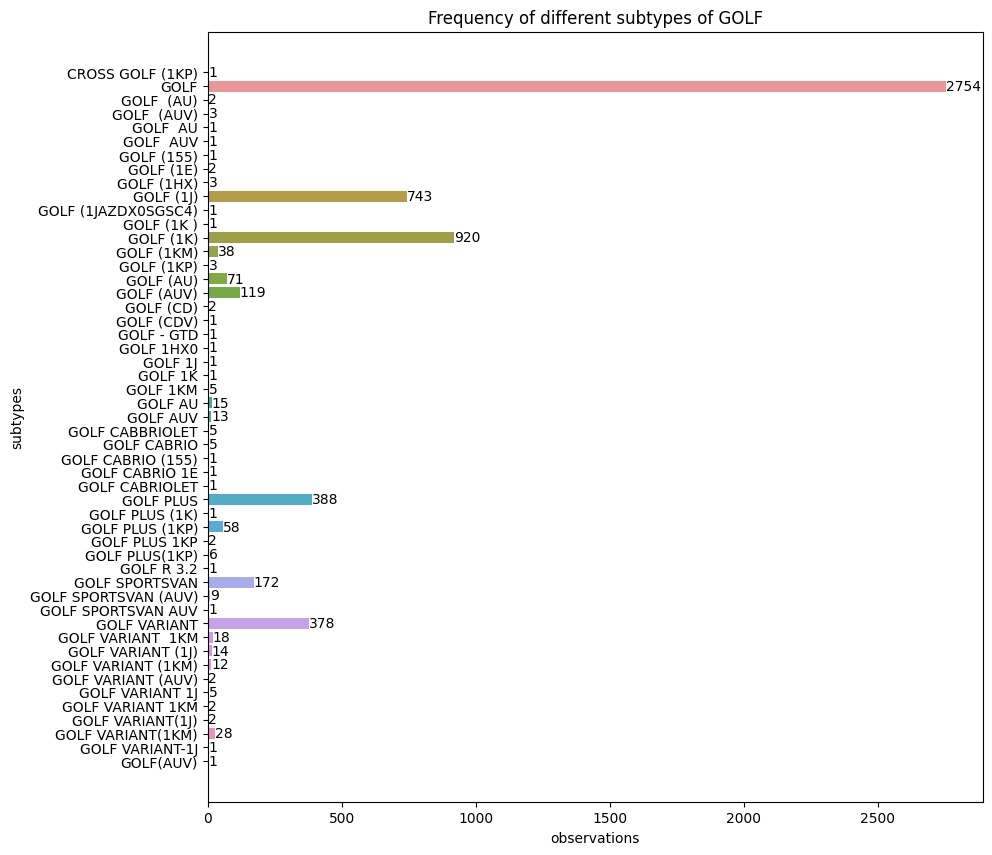

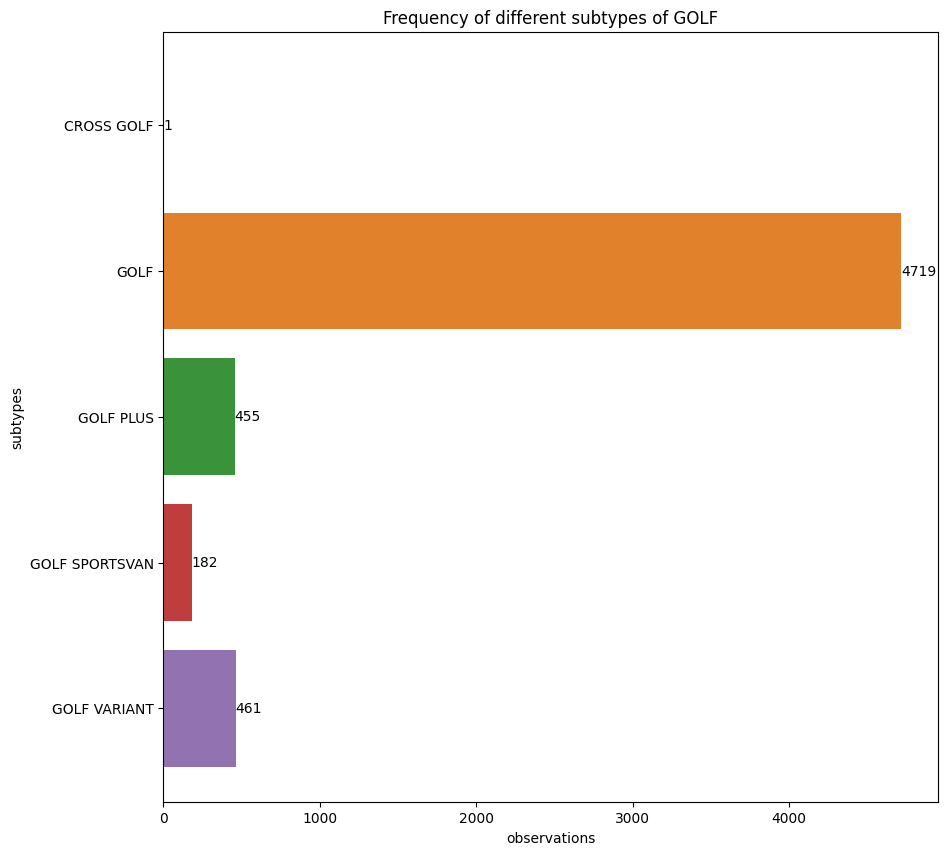

In [105]:
# Test
import matplotlib.pyplot as plt
import seaborn as sns


df = read_xml(f'data/nosync/data_raw/Data_2021/Data_Prohlidek_2021_06.xml')
df = filter_vehicle_types(df, '')


def vis(df, make, mod):
    octas = df[(df['Make'] == make) & (df['Model'].str.contains(mod) == True)]
    octas = octas['Model'].to_numpy()
    vals, counts = np.unique(octas, return_counts=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    g = sns.barplot(x=counts, y=vals, orient='h')
    # g.set_xscale("log")
    g.set(title=f"Frequency of different subtypes of {mod}",
          xlabel="observations", ylabel="subtypes")
    ax.bar_label(ax.containers[0])
    g.plot()


vis(df, 'VOLKSWAGEN', 'GOLF')
dfx = group_models(df, '')
# dfx=df
# df['Model'] = df['Model'].apply(lambda x: x.split('(')[0].strip())
# df['Model'] = df['Model'].str.replace('[^\w\s]', '', regex=True)
# df['Model'] = df['Model'].str.replace('  ', ' ')
# df['Model'] = df['Model'].str.replace('   ', ' ')
vis(dfx, 'VOLKSWAGEN', 'GOLF')


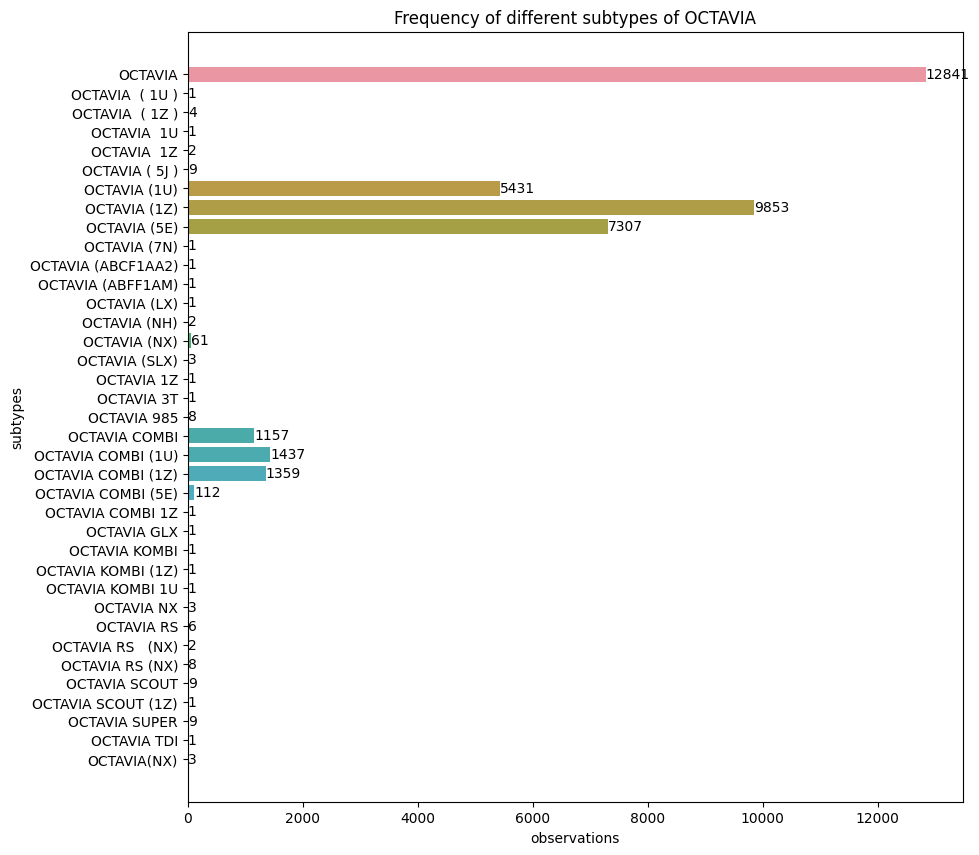

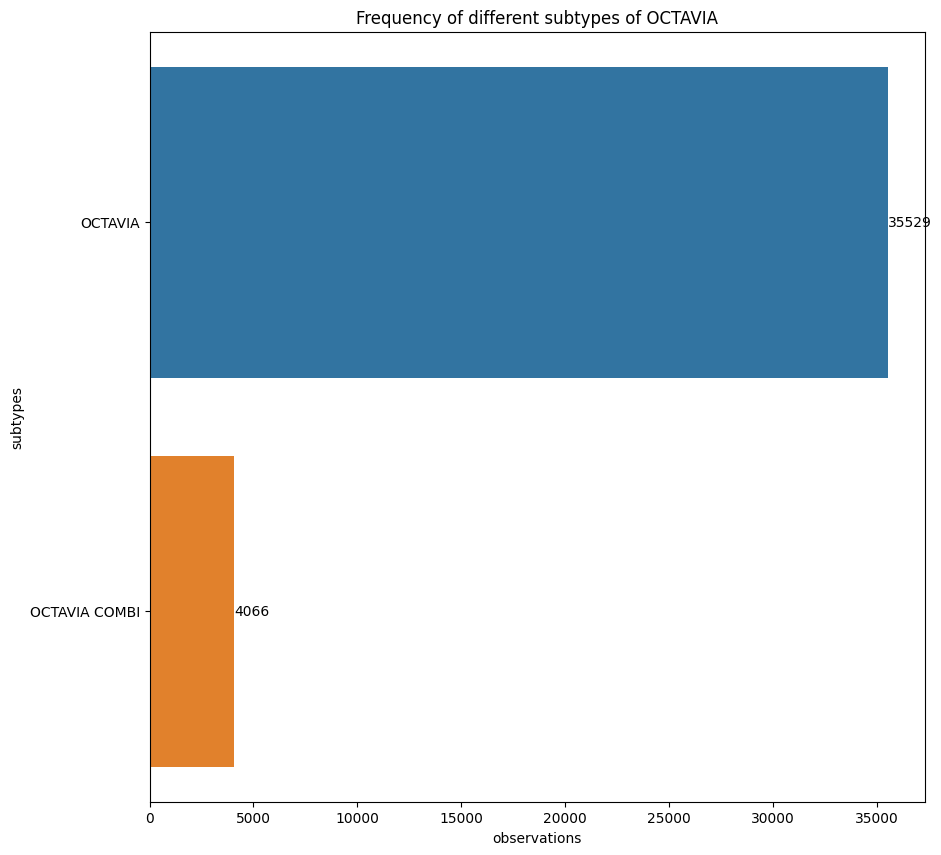

In [108]:
df = read_xml(f'data/nosync/data_raw/Data_2021/Data_Prohlidek_2021_06.xml')
vis(df, 'ŠKODA', 'OCTAVIA')
vis(dfx, 'ŠKODA', 'OCTAVIA')

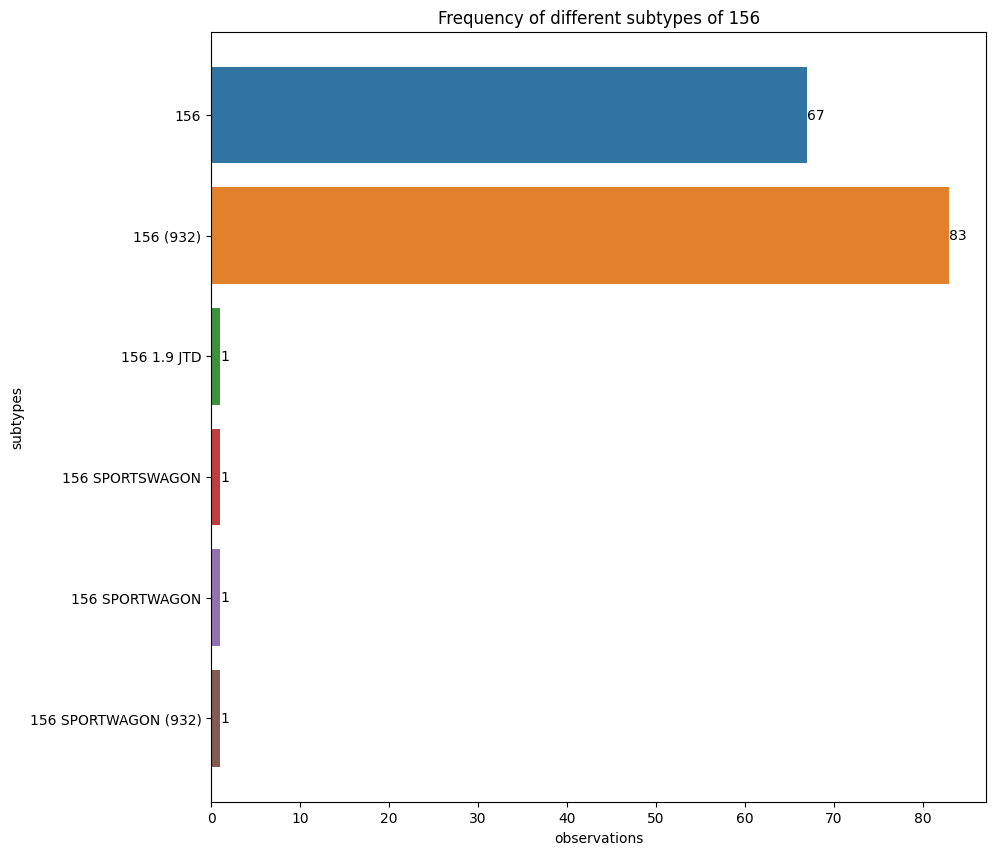

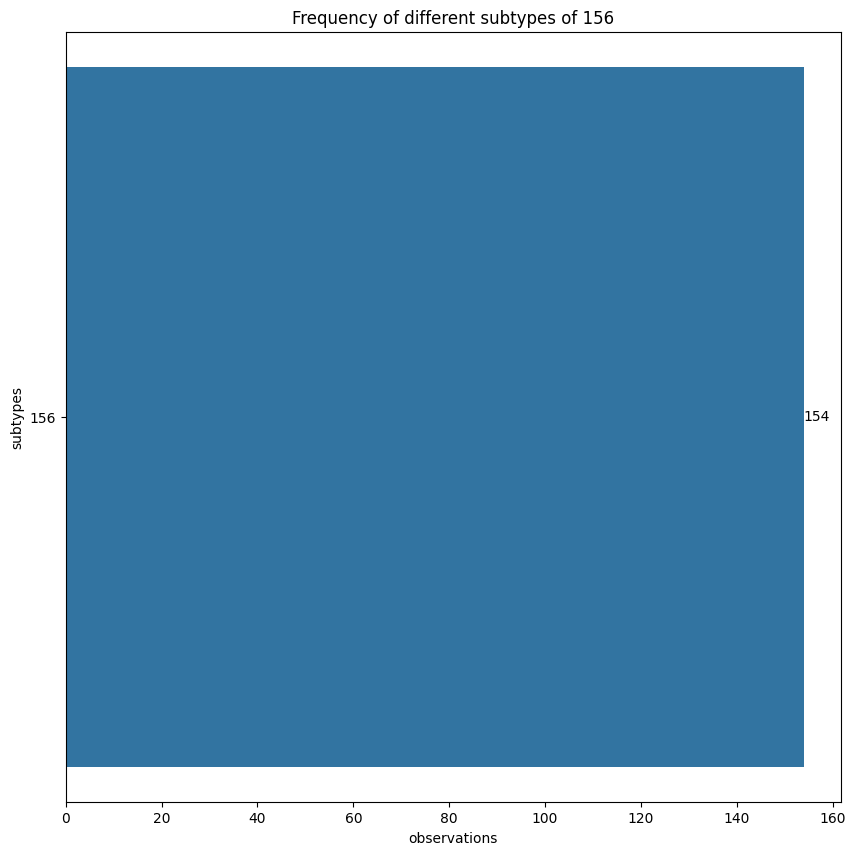

In [109]:
vis(df, 'ALFA ROMEO', '156')
vis(dfx, 'ALFA ROMEO', '156')

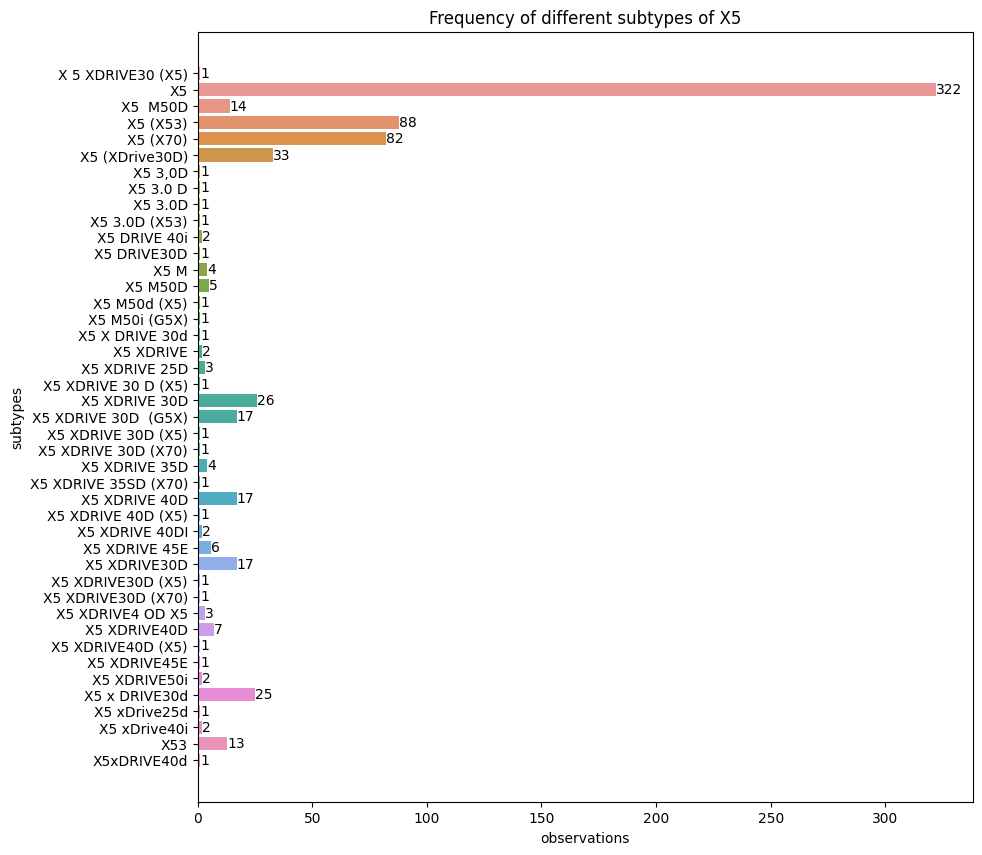

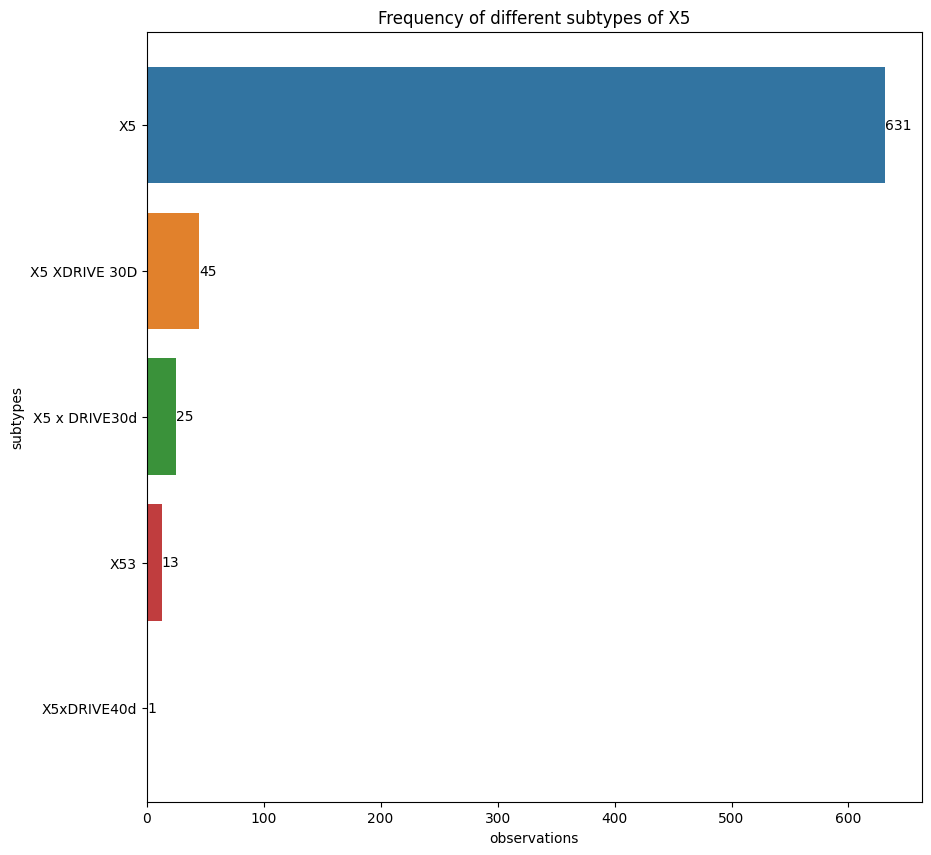

In [110]:
vis(df, 'BMW', 'X5')
vis(dfx, 'BMW', 'X5')

### First registration date
Filter outliers.
This is just temporary for EDA, won't be used further as registration info will be taken from the vehicle register.

In [64]:
def filter_first_reg_date(df: pd.DataFrame, name: str) -> pd.DataFrame:
    year = int(name.split('-')[0])
    month = int(name.split('-')[1])

    if month < 12:
        next_month = f'{year}-{month + 1:02}-01'
    else:
        next_month = f'{year + 1}-01-01'

    # Filter 1900-01-01 as well, because those are likely errors as well.
    return df[(df['FirstRegistrationDate'] >= '1900-01-02') & (df['FirstRegistrationDate'] < next_month)]


pipeline.append(filter_first_reg_date)


In [17]:
# Test
filter_first_reg_date(df, '2021-06')['FirstRegistrationDate'].describe()


/tmp/ipykernel_65114/1823422221.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  filter_first_reg_date(df, '2021-06')['FirstRegistrationDate'].describe()


count                  421208
unique                  15587
top       2017-06-28 00:00:00
freq                     1033
first     1900-02-28 00:00:00
last      2021-06-30 00:00:00
Name: FirstRegistrationDate, dtype: object

### Km
Filter outliers.
This is just temporary for EDA.
Outliers will be however separated before analysis.

In [65]:
def filter_km(df: pd.DataFrame, _) -> pd.DataFrame:
    df['Km'] = df['Km'].astype('int')
    return df[df['Km'] <= 1000000]


pipeline.append(filter_km)


0


141703    1503420.0
305605    1504528.0
25147     1506346.0
317769    1533051.0
374466    1534976.0
            ...    
226929    3740696.0
297195    4923526.0
136167    5287400.0
383911    7373564.0
6620      9781163.0
Name: Km, Length: 145, dtype: float64

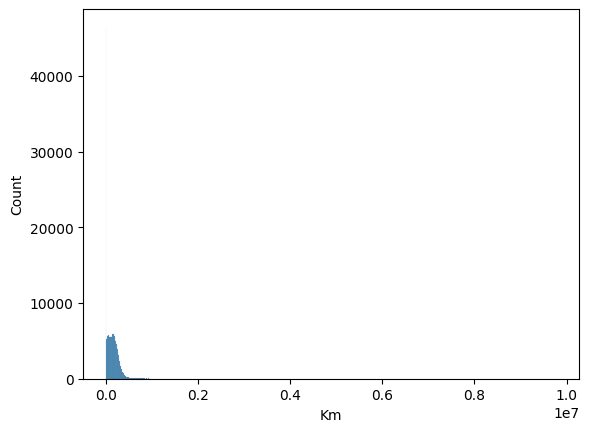

In [121]:
# Test

df['Km'] = df['Km'].astype('float64', errors='ignore')
df['Km'].describe()
sns.histplot(df['Km'])

print(df['Km'].isna().sum())
display(df[df['Km'] > 1500000]['Km'].sort_values())

### Results

In [66]:
def transform_results(df: pd.DataFrame, _) -> pd.DataFrame:
    df['Result'] = df['Result'].astype('category')
    return df


pipeline.append(transform_results)


## Additional columns

### Add weekday

In [67]:
def add_weekday(df: pd.DataFrame, _) -> pd.DataFrame:
    df['Weekday'] = df['Date'].apply(lambda date: date.isoweekday())
    return df


pipeline.append(add_weekday)


### Defects

In [68]:
# Add counts of failures by type.

# Load defect list.
defects = pd.read_csv('../defect_list/data/defect_list.csv')
defects.set_index('Code', inplace=True)


def count_failures(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """"Add DefectsA, DefectsB, DefectsC (count of failures by severity) based on the contents of `Defects`"""

    # Skip 2018
    if name.startswith('2018'):
        df['DefectsA'] = 0
        df['DefectsB'] = 0
        df['DefectsC'] = 0

        return df

    def map_failures(row):
        failure_codes = str(row['Defects']).split(',')
        if len(failure_codes) == 0:
            return (0, 0, 0)
        else:
            a = 0
            b = 0
            c = 0
            for failure_code in failure_codes:
                type = None
                try:
                    type = defects['Type'].loc[failure_code]
                except:
                    pass
                if type == 'A':
                    a = a + 1
                if type == 'B':
                    b = b + 1
                if type == 'C':
                    c = c + 1
            return (a, b, c)

    df[['DefectsA', 'DefectsB', 'DefectsC']] = df.apply(
        map_failures, axis=1, result_type='expand')
    return df


pipeline.append(count_failures)


In [69]:
# Add counts of failures by first-level category

def count_failures_by_fl_cat(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """"Add Defects0-9 (count of failures by first-level category) based on the contents of `Defects`"""

    # Skip 2018
    if name.startswith('2018'):
        for col in ['Defects0', 'Defects1', 'Defects2', 'Defects3', 'Defects4', 'Defects5', 'Defects6',
                    'Defects7', 'Defects8', 'Defects9']:
            df[col] = 0

        return df

    def map_failures(row):
        failure_codes = str(row['Defects']).split(',')
        if len(failure_codes) == 0:
            return (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        else:
            fs = [0 for i in range(10)]
            for failure_code in failure_codes:
                fln = -1
                try:
                    fln = int(failure_code.split('.')[0])
                except:
                    pass
                if fln >= 0 and fln <= 9:
                    fs[fln] = fs[fln] + 1
            return (fs[0], fs[1], fs[2], fs[3], fs[4], fs[5], fs[6], fs[7], fs[8], fs[9])

    df[['Defects0', 'Defects1', 'Defects2', 'Defects3', 'Defects4', 'Defects5', 'Defects6',
        'Defects7', 'Defects8', 'Defects9']] = df.apply(map_failures, axis=1, result_type='expand')
    return df


pipeline.append(count_failures_by_fl_cat)


### Vehicle age

In [70]:
# Add vehicle age in days. (float to support nan)
# The age is relative to the *date of the inspection.*


def count_vehicle_age(df: pd.DataFrame, _) -> pd.DataFrame:
    df['AgeDays'] = df.apply(
        lambda row: (row['Date'] - row['FirstRegistrationDate']).days, axis=1, result_type=None)

    return df


pipeline.append(count_vehicle_age)


In [71]:
# # Process categorical indicators

# # 1. Gather all possible values, save them.
# cat_ind = ['StationId', 'Type', 'MotorType', 'Make', 'VehicleType', 'Model', 'VehicleClass']
# cat_ind_vals = {cat: set() for cat in cat_ind}

# def gather_categorical(df: pd.DataFrame) -> pd.DataFrame:
    
#     def process(row):
#         for cat in cat_ind:
#             cat_ind_vals[cat].add(row[cat])

#     df.apply(process, axis=1)
#     return df

# append_pipeline_for_all(gather_categorical)

# # # 2. Drop currently unusable variables.
# # def drop_useless(df: pd.DataFrame) -> pd.DataFrame:
# #     df = df.drop(['TypMot'])

# #     return df

# # 2. Convert categorical values to dummy variables
# #    Adjust this step to include only variables that are needed for analysis

# # 3. Convert VyslSTK, VyslEmise to an ordinal value
# #    VyslSTK:
# #      zpusobile: 0
# #      castecne zpusobile: 1
# #      nezpusobile: 2
# #    VyslEmise:
# #      vyhovuje: 0
# #      nevyhovuje: 1

## Run the pipeline

In [73]:
# Run the pipeline
def run(df: pd.DataFrame, name: str):
    for func in pipeline:
        print("  " + func.__name__)
        df = func(df, name)
        # print(df.head())
    return df

# Save gathered categorical values.
# import json
# with open('categories.json', "w") as fp:
#     json.dump({cat: list(cat_ind_vals[cat]) for cat in cat_ind}, fp)

In [27]:
# Load raw xmls
dirs_raw = {}

for dir in os.listdir(data_raw):
    if not os.path.isdir(data_raw + '/' + dir):
        continue
    for instance in os.listdir(data_raw + '/' + dir):
        year = instance.split('.')[0].split('_')[2]
        month = instance.split('.')[0].split('_')[3]
        name = f'{year}-{month}'
        print(name)
        print('  read_xml')
        df = read_xml(f'{data_raw}/{dir}/{instance}')

        df = run(df, name)

        df.to_csv(f'{data_csv}/{year}-{month}.csv')


2019-09
  read_xml
  process_missing
  filter_vehicle_types
  filter_duplicates
  filter_incomplete
  filter_vins
  filter_unknown_stations
  transform_inspection_type
  format_date
  filter_dates_out_of_range
  group_models
  filter_first_reg_date
  filter_km
  transform_results
  add_weekday
  count_failures
  count_failures_by_fl_cat
  count_vehicle_age
2019-07
  read_xml
  process_missing
  filter_vehicle_types
  filter_duplicates
  filter_incomplete
  filter_vins
  filter_unknown_stations
  transform_inspection_type
  format_date
  filter_dates_out_of_range
  group_models
  filter_first_reg_date
  filter_km
  transform_results
  add_weekday
  count_failures
  count_failures_by_fl_cat
  count_vehicle_age
2019-06
  read_xml
  process_missing
  filter_vehicle_types
  filter_duplicates
  filter_incomplete
  filter_vins
  filter_unknown_stations
  transform_inspection_type
  format_date
  filter_dates_out_of_range
  group_models
  filter_first_reg_date
  filter_km
  transform_results
 

In [75]:
# Handle 2018 separately to split months.
# This needs a few gigs of RAM.

all_data = read_xml(f'{data_raw}/Seznam_prohlídek_STK_2018.xml')

# Filter out each month and process it separately.
for month in range(1, 13):
    datepadded = f'2018-{str(month).rjust(2, "0")}'
    print(datepadded)
    
    # Flag rows from the current month.
    all_data['retain'] = all_data['Date'].apply(
        lambda val: True if val.startswith(datepadded) else False)
    # Save positively flagged rows without the flag column.
    data = all_data[all_data['retain']].loc[:, all_data.columns != 'retain']

    data = run(data, datepadded)

    data.to_csv(f'{data_csv}/{datepadded}.csv')


2018-01
  StationId                Type                VIN                     Date  \
0      3122  Evidenční kontrola  JMZBLA2G601258504  2018-01-02T11:03:12.833   
1      3205  Evidenční kontrola            4150417  2018-01-02T11:06:07.617   
2      3114  Evidenční kontrola  VF3MJAHXHGS280168  2018-01-02T11:15:08.083   
3      3618  Evidenční kontrola            4699845  2018-01-02T11:19:22.967   
4      3748  Evidenční kontrola  WF0SXXGCDSAU06730  2018-01-02T11:30:25.420   

  MotorType     Make       VehicleType        Model VehicleClass  \
0        LF    MAZDA  OSOBNÍ AUTOMOBIL            3           M1   
1   EM150.2       MZ          MOTOCYKL      ETZ 150          L3e   
2      AH01  PEUGEOT  OSOBNÍ AUTOMOBIL         3008           M1   
3      1202    ŠKODA  OSOBNÍ AUTOMOBIL         1202           M1   
4      GPDC     FORD  OSOBNÍ AUTOMOBIL  FOCUS (DA3)           M1   

  FirstRegistrationDate      Km Defects     Result  
0   2011-02-10T00:00:00   84818          způsobilé  
1 

In [143]:
dfx = run(df, '2021-06')

  process_missing
  filter_vehicle_types
  filter_duplicates
  filter_incomplete
  filter_vins
  filter_unknown_stations
  transform_inspection_type
  format_date
  filter_dates_out_of_range
  group_models
Make: ACCESS
Make: ADAMS
Make: ADLY
Make: ADRIA
Make: AEBI
Make: AGADOS
Make: AGM
Make: AIXAM
Make: AKUMOTO
Make: ALFA ROMEO
Good 2w candidate: 156 SPORTSWAGON (1) (group to "156" with 96 occrs)
Good 2w candidate: 156 SPORTWAGON (2) (group to "156" with 96 occrs)
Good mw->1w candidate: 156 19 JTD (1) (group to "156" with 96 occrs)
Make: APRILIA
Make: ARCA
Make: ARCA CAMPER
Make: ARCTIC CAT
Make: ARO
Good 2w candidate: 330 td (1) (group to "330" with 175 occrs)
Make: ARTIC CAT
Make: ASIA
Make: ASTRA
Make: ATTACK ROADSTER
Make: ATV
Make: AUDI
Good 2w candidate: 80 AVANT (8) (group to "80" with 78 occrs)
Good 2w candidate: 80 CABRIOLET (1) (group to "80" with 78 occrs)
Good 2w candidate: A3 S3 (2) (group to "A3" with 565 occrs)
Good 2w candidate: A4 CABRIOLET (24) (group to "A4" with 68

In [144]:
dfx.to_csv(f'{data_csv}/2021-06.csv')

In [61]:
pipeline

[<function __main__.process_missing(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.filter_vehicle_types(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.filter_duplicates(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.filter_incomplete(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.filter_vins(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.filter_unknown_stations(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.transform_inspection_type(df: pandas.core.frame.DataFrame, _)>,
 <function __main__.format_date(df: pandas.core.frame.DataFrame, name: str)>,
 <function __main__.filter_dates_out_of_range(df: pandas.core.frame.DataFrame, name: str)>,
 <function __main__.group_models(df: pandas.core.frame.DataFrame, _) -> pandas.core.frame.DataFrame>,
 <function __main__.filter_first_reg_date(df: pandas.core.frame.DataFrame, name: str) -> pandas.core.frame.DataFrame>,
 <function __main__.filter_km(df: pandas.core.frame.DataFrame, _) ->

In [44]:
df.apply(lambda row: (row['Date'] - row['FirstRegistrationDate']).days, axis=1, result_type=None)

TypeError: unsupported operand type(s) for -: 'str' and 'str'